<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOpsHomeAssignment_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2024-03-17 14:35:25--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.229.13, 52.84.229.87, 52.84.229.68, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.229.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  10.9MB/s    in 4.2s    

2024-03-17 14:35:30 (10.7 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Epoch [1/10], Loss: 0.0141
Epoch [2/10], Loss: 0.0080
Epoch [3/10], Loss: 0.0066
Epoch [4/10], Loss: 0.0074
Epoch [5/10], Loss: 0.0055
Epoch [6/10], Loss: 0.0055
Epoch [7/10], Loss: 0.0064
Epoch [8/10], Loss: 0.0050
Epoch [9/10], Loss: 0.0057
Epoch [10/10], Loss: 0.0059


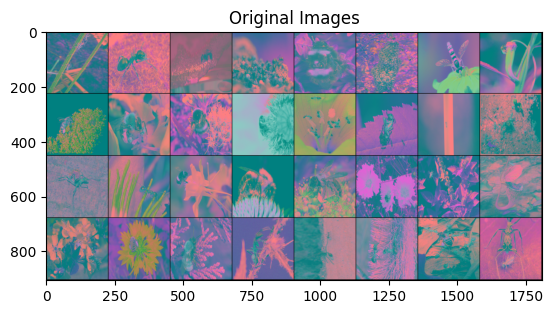

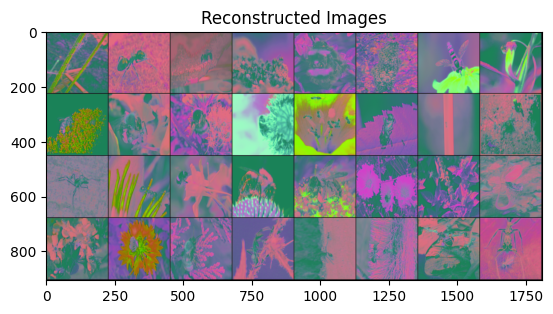

MSE Loss: 0.0052, RMSE Loss: 0.0722, SSIM: 0.0000, PSNR: 0.0000


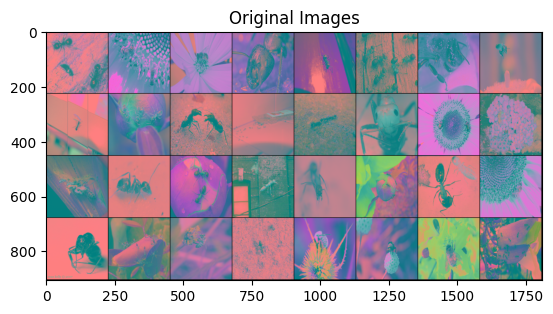

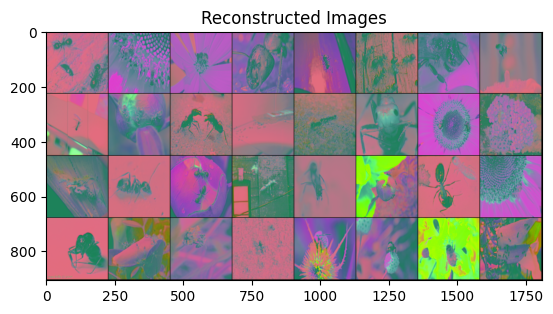

MSE Loss: 0.0053, RMSE Loss: 0.0728, SSIM: 0.0000, PSNR: 0.0000


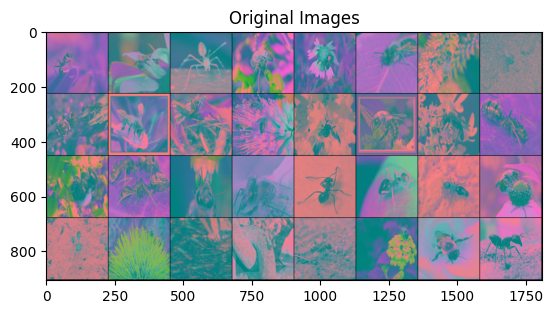

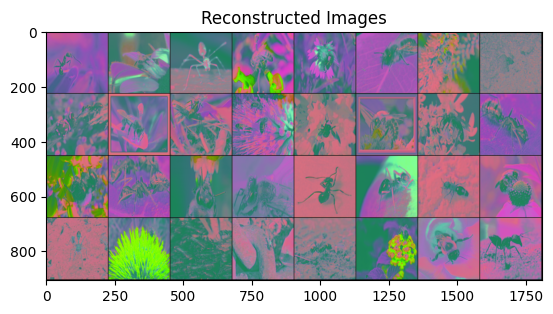

MSE Loss: 0.0049, RMSE Loss: 0.0698, SSIM: 0.0000, PSNR: 0.0000


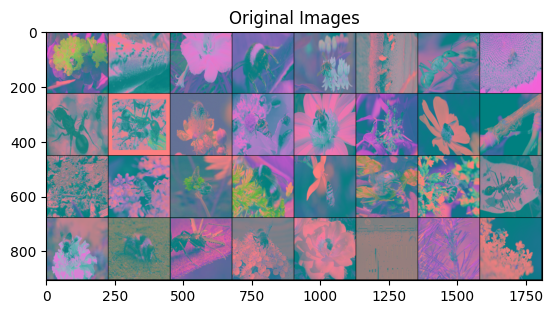

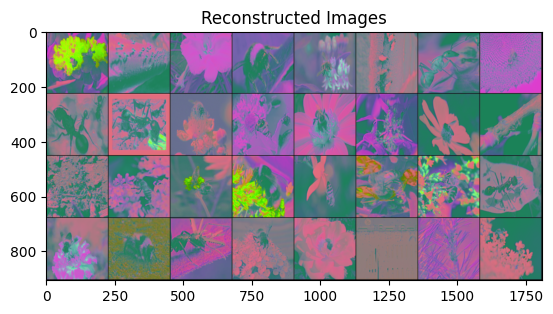

MSE Loss: 0.0047, RMSE Loss: 0.0685, SSIM: 0.0000, PSNR: 0.0000


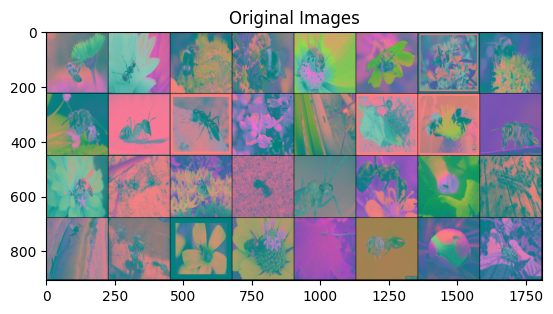

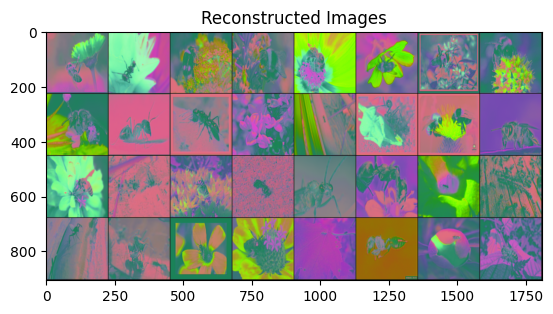

MSE Loss: 0.0084, RMSE Loss: 0.0915, SSIM: 0.0000, PSNR: 0.0000


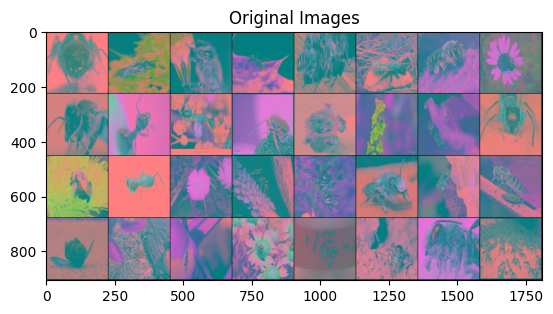

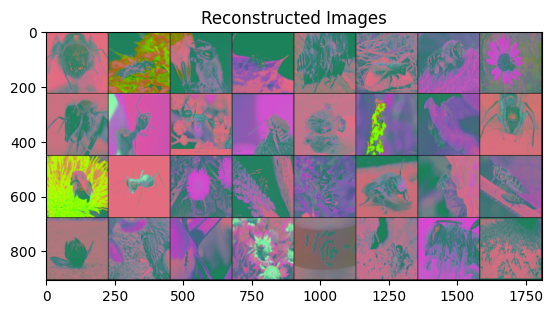

MSE Loss: 0.0053, RMSE Loss: 0.0726, SSIM: 0.0000, PSNR: 0.0000


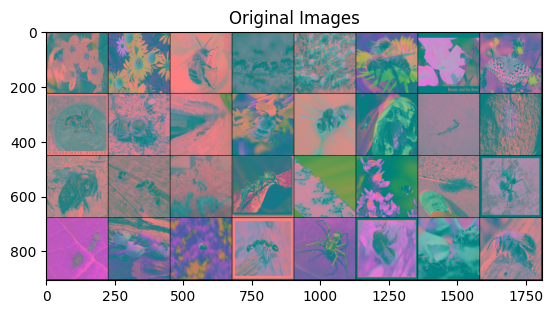

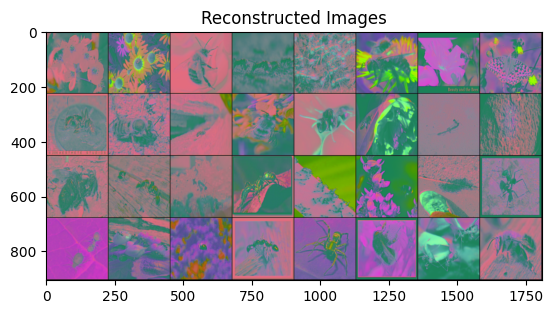

MSE Loss: 0.0043, RMSE Loss: 0.0659, SSIM: 0.0000, PSNR: 0.0000


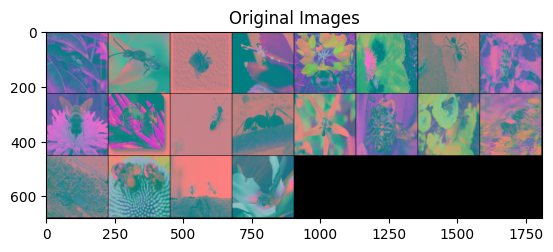

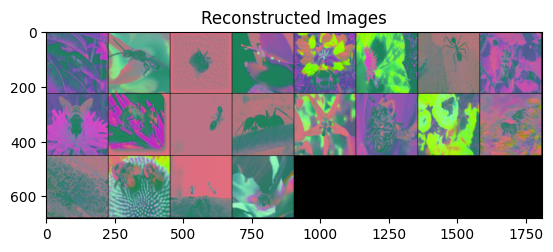

MSE Loss: 0.0058, RMSE Loss: 0.0759, SSIM: 0.0000, PSNR: 0.0000


<ipython-input-17-e6341eb022cc>:131: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')


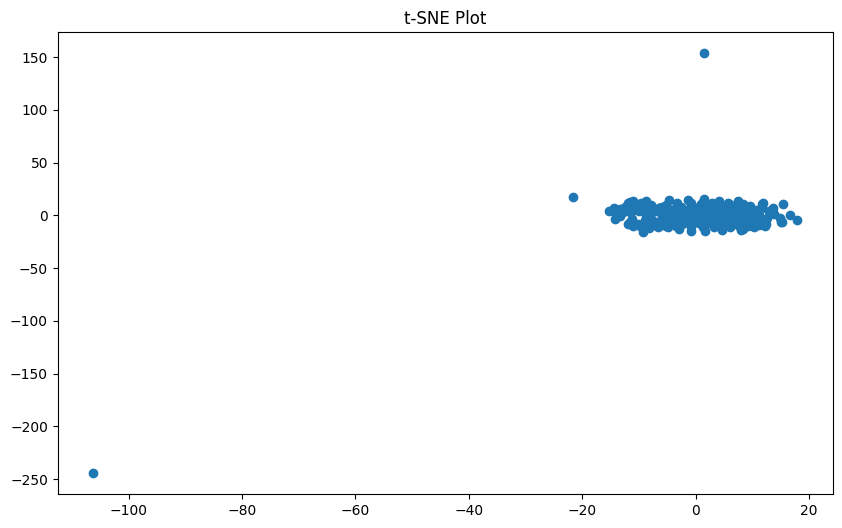

<ipython-input-17-e6341eb022cc>:138: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')


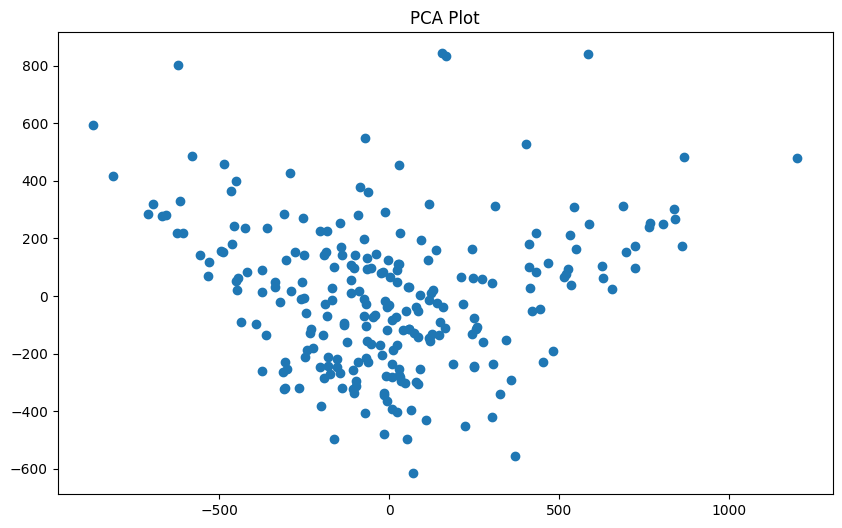

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage import color
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train', transform=transform)

def rgb_to_lab(img):
    lab_img = color.rgb2lab(img.permute(1, 2, 0).cpu().numpy())
    lab_img[:, :, 0] /= 100.0
    lab_img[:, :, 1:] = (lab_img[:, :, 1:] + 128) / 255.0
    return torch.tensor(lab_img.transpose(2, 0, 1)).float()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        lab_img = rgb_to_lab(img)
        return lab_img

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            #nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

custom_dataset = CustomDataset(hymenoptera_dataset)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

autoencoder_writer = SummaryWriter()

for epoch in range(num_epochs):
    for data in dataloader:
        img = data.to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    autoencoder_writer.add_scalar('Loss/train', loss.item(), epoch)

# Step 5: Evaluation
model.eval()
with torch.no_grad():
    for data in dataloader:
        img = data.to(device)
        recon = model(img)
        mse_loss = nn.MSELoss()(recon, img).item()
        rmse_loss = torch.sqrt(torch.tensor(mse_loss)).item()
        ssim = 0
        psnr = 0

        original_grid = vutils.make_grid(img.cpu(), nrow=8, normalize=True)
        recon_grid = vutils.make_grid(recon.cpu(), nrow=8, normalize=True)

        plt.imshow(np.transpose(original_grid, (1, 2, 0)))
        plt.title('Original Images')
        plt.show()
        plt.imshow(recon_grid.permute(1, 2, 0))
        plt.title('Reconstructed Images')
        plt.show()

        print(f'MSE Loss: {mse_loss:.4f}, RMSE Loss: {rmse_loss:.4f}, SSIM: {ssim:.4f}, PSNR: {psnr:.4f}')

features = []
model.eval()
with torch.no_grad():
    for data in dataloader:
        img = data.to(device)
        feature = model.encoder(img)
        features.append(feature.view(feature.size(0), -1).cpu().numpy())

features = np.concatenate(features, axis=0)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(features)
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], cmap='viridis')
plt.title('t-SNE Plot')
plt.show()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='viridis')
plt.title('PCA Plot')
plt.show()

X_train, X_val = train_test_split(features, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2

classifier = MLPClassifier(input_size, hidden_size, num_classes).to(device)

criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=0.001)

classifier_writer = SummaryWriter()

num_epochs_classifier = 10

for epoch in range(num_epochs_classifier):
    classifier.train()
    optimizer_classifier.zero_grad()
    outputs = classifier(X_train_tensor)
    loss = criterion_classifier(outputs, torch.zeros(X_train_tensor.shape[0], dtype=torch.long).to(device))
    loss.backward()
    optimizer_classifier.step()

    classifier.eval()
    with torch.no_grad():
        val_outputs = classifier(X_val_tensor)
        val_loss = criterion_classifier(val_outputs, torch.zeros(X_val_tensor.shape[0], dtype=torch.long).to(device))
        val_preds = torch.argmax(val_outputs, dim=1)

    classifier_writer.add_scalar('Loss/train', loss.item(), epoch)
    classifier_writer.add_scalar('Loss/val', val_loss.item(), epoch)

autoencoder_writer.close()
classifier_writer.close()